### Hey guys, in this notebook, I will do some EDA and use LSTM to predict and analyze daily climate.
**Base on this data, there's something we can alalyze and I will show it below.** 
> Here's the table of contents:
1. [Time Series Analysis](#part1)
2. [Seasonal Analysis](#part2)
3. [Correlation Analysis](#part3)
4. [Anomaly Detection](#part4)
5. [LSTM forecasting](#part5)  
**First, let's import some necessary libraries and take a look at our data.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install adtk
from adtk.data import validate_series
from adtk.detector import SeasonalAD, LevelShiftAD, VolatilityShiftAD, InterQuartileRangeAD
from adtk.visualization import plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
print(df.shape)
df.head()

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
# check out date type and find null data
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


<a id="part1"><a/>
## Part 1: Time Sereis Analysis  
Study the trends of various climate variables (like temperature, humidity, etc.) over time.

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

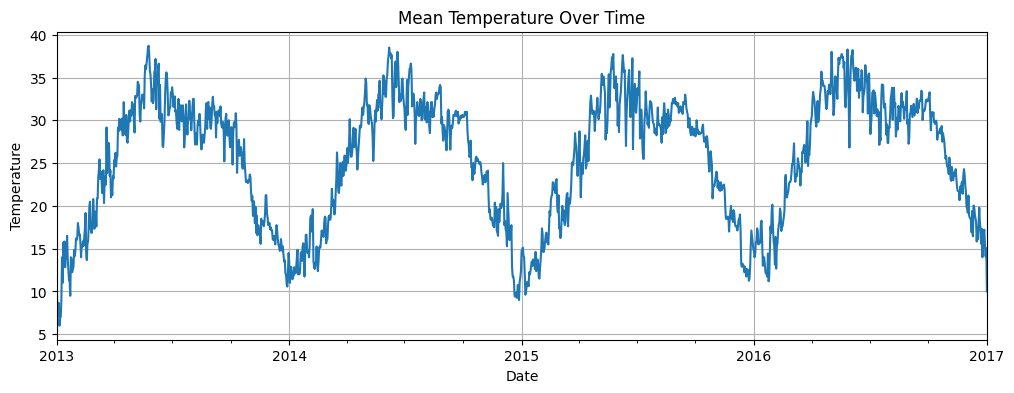

In [106]:
plt.figure(figsize=(12,4))
df['meantemp'].plot()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Mean Temperature Over Time')
plt.grid(visible=True)

**There's doesn't appear a significant trend, but we can see some seasonal trend**

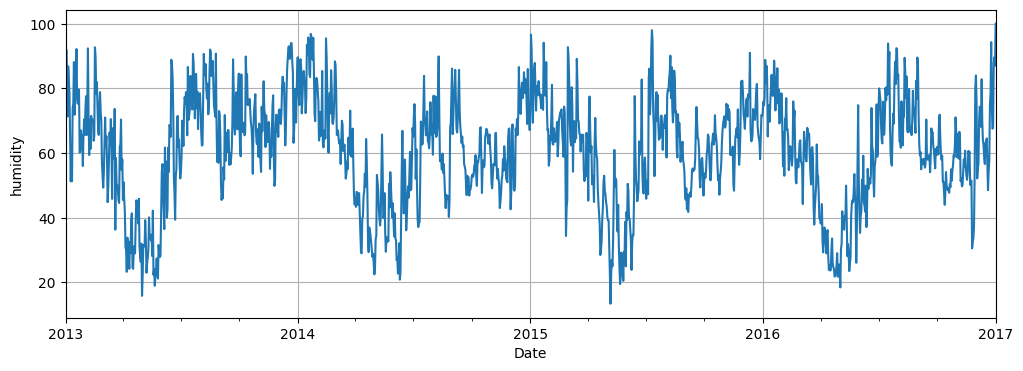

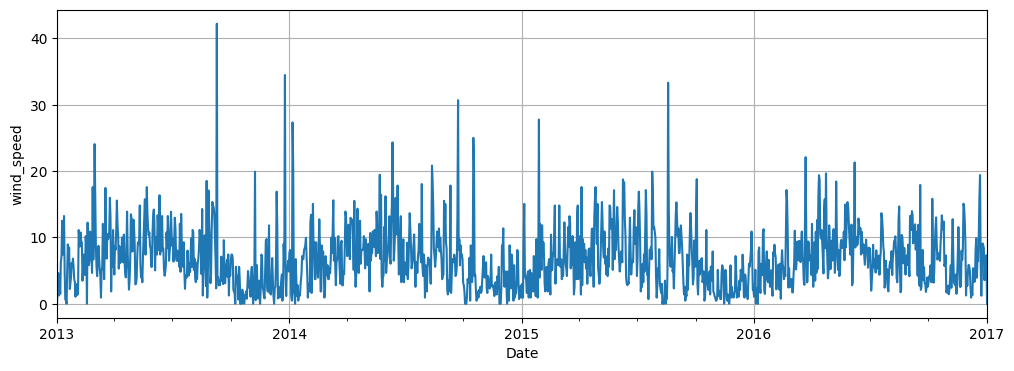

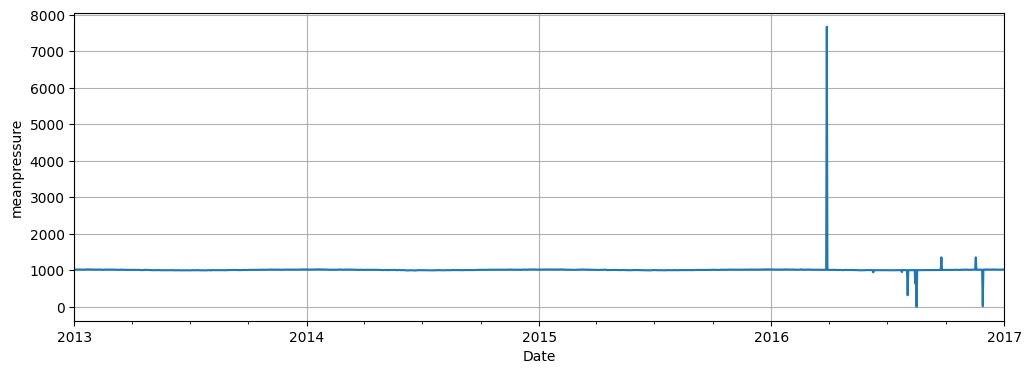

In [107]:
# We can also see other time series trend
def plot_timeseries(variable):
    plt.figure(figsize=(12,4))
    df[variable].plot()
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.grid(visible=True)
plot_timeseries('humidity')
plot_timeseries('wind_speed')
plot_timeseries('meanpressure')

1. **Humidity:** Overall, it seems relatively stable, but there are some seasonal fluctuations.
2. **Wind Speed:** The data shows some fluctuations, but no clear trend.
3. **Mean Pressure:** This indicator exhibits some notable outliers and fluctuations.

## Seasonal Decomposition  
Breaking down the 'meantemp' data into its underlying trend, seasonality, and residuals. The Seasonal-Trend decomposition using LOESS (STL) provides a way to study the underlying trend in the mean temperature over time. This helps us understand how the mean temperature has been changing, excluding seasonal variations and random noise.

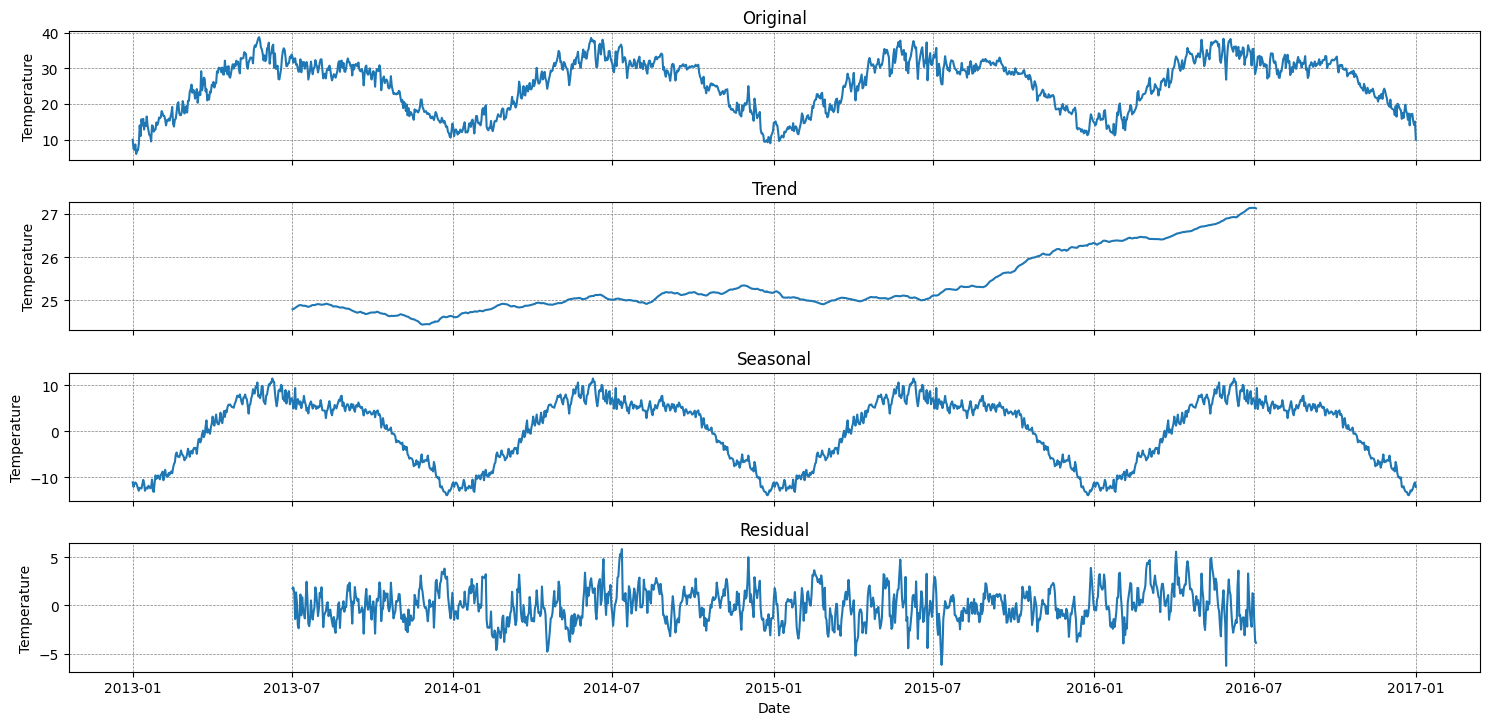

In [101]:
decomposition = seasonal_decompose(df['meantemp'], model='additive', period=365)
fig, ax = plt.subplots(4,1, figsize=(15,8), sharex=True)
ax[0].plot(decomposition.observed)
ax[0].set_title('Original')
ax[0].set_ylabel('Temperature')
ax[0].grid(True, color='gray', linestyle='--', linewidth=0.5)
ax[1].plot(decomposition.trend)
ax[1].set_title('Trend')
ax[1].set_ylabel('Temperature')
ax[1].grid(True, color='gray', linestyle='--', linewidth=0.5)
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal')
ax[2].set_ylabel('Temperature')
ax[2].grid(True, color='gray', linestyle='--', linewidth=0.5)
ax[3].plot(decomposition.resid)
ax[3].set_title('Residual')
ax[3].set_ylabel('Temperature')
ax[3].set_xlabel('Date')
ax[3].grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

1. Original: This is the original time series data of the mean temperature.
2. Trend: This component shows the general upward or downward movement of the data over time. Here, we can see some slight long-term fluctuations.
3. Seasonal: This represents the regular pattern in the data that repeats over time. The seasonal component is quite pronounced, indicating yearly cyclical changes.
4. Residual: These are the remaining random fluctuations after removing the trend and seasonal components.  

## Delve deeper into time series analysis  
1. **Stationarity Check:** This involves assessing whether the statistical properties of the time series data are constant over time. Stationarity is important because many time series models assume it.

2. **Autocorrelation and Partial Autocorrelation Plots:** These plots help us understand the relationship between an observation and its previous observations (lags). This is crucial for identifying patterns and potentially building forecasting models.

3. **Rolling Statistics:** We'll look at moving averages and moving standard deviations to better understand trends and variability in the data over time.

In [10]:
# Perform Augmented Dickey-Fuller test to check for stationarity
result = adfuller(df['meantemp'])
print(f"ADF Statistic: {result[0]}")
print(f"P value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -2.021069055920673
P value: 0.2774121372301602
Critical Values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


**Base on this data, the p-value is greater than 0.05, which means we can't reject H0(the data is not stationary). We should transorm non-stationary data into stationary data.(if we use statisic method to predict temperature)**

In [12]:
# we use Differencing to transform our data
temp_diff = df['meantemp'].diff().dropna()
result_diff = adfuller(temp_diff)
print(f"ADF Statistic: {result_diff[0]}")
print(f"P value: {result_diff[1]}")
print(f"Critical Values: {result_diff[4]}")

ADF Statistic: -16.378720267074687
P value: 2.764863137594565e-29
Critical Values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


**Now p-value is smaller than 0.05, we transformed our data successfully.**  

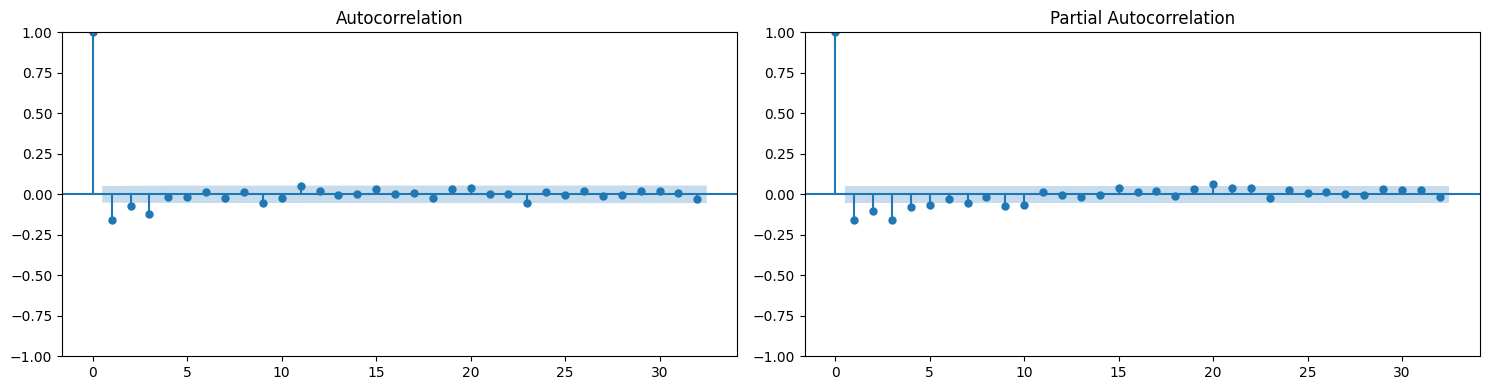

In [15]:
# Autocorrelation and Partial Autocorrelation Plots
fig, ax = plt.subplots(1,2, figsize=(15,4))
plot_acf(temp_diff, ax=ax[0])
plot_pacf(temp_diff, ax=ax[1])
plt.tight_layout()

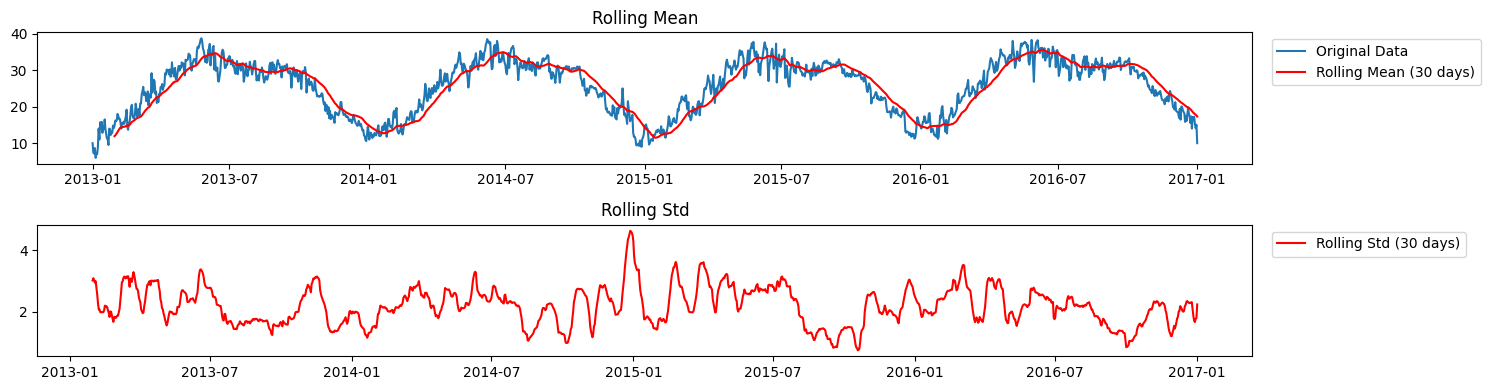

In [33]:
# rolling Satistic
rolling_mean = df['meantemp'].rolling(window=30).mean()
rolling_std = df['meantemp'].rolling(window=30).std()
plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
plt.plot(df['meantemp'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='red')
plt.title('Rolling Mean')
plt.legend(bbox_to_anchor=[1.01,1], loc='upper left')

plt.subplot(2,1,2)
plt.plot(rolling_std, label='Rolling Std (30 days)', color='red')
plt.title('Rolling Std')
plt.legend(bbox_to_anchor=[1.01,1], loc='upper left')
plt.tight_layout()

**The rolling average line closely tracks the original data line, indicating that there is a relatively stable long-term trend in the data, with no apparent seasonal or cyclical variations.**

<a id="part2"><a/>
## Part 2: Seasonal Analysis
Investigate whether there are seasonal variations, like whether summers are generally hotter or more humid.

In [12]:
df['month'] = df.index.month
df['year'] = df.index.year
df_season = df.groupby(['year', 'month']).mean()

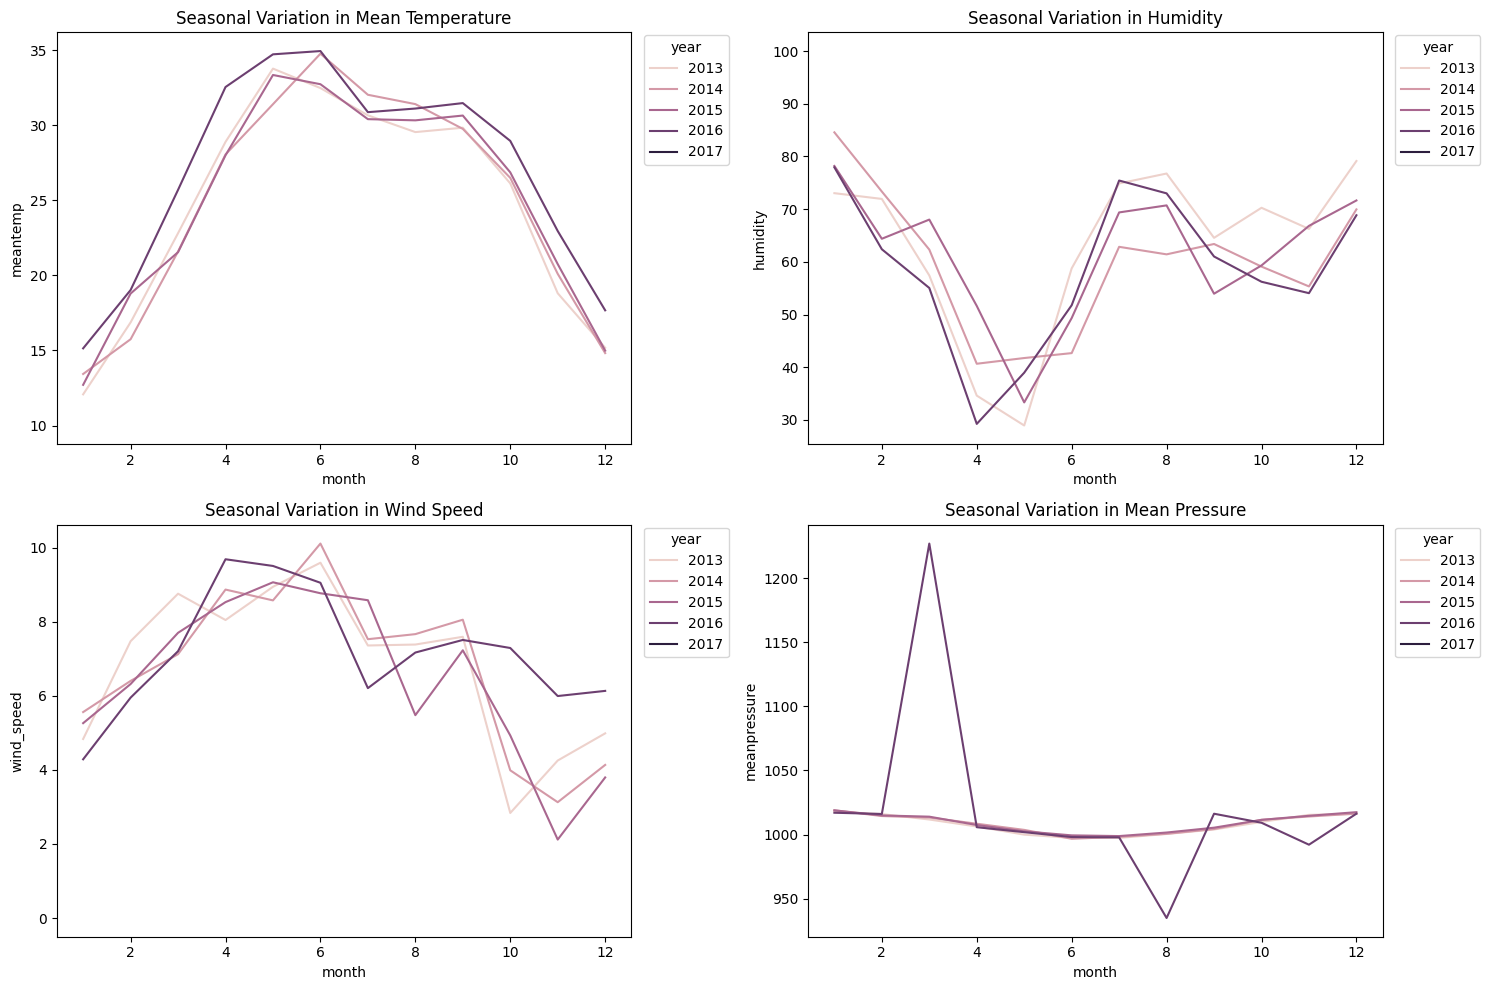

In [46]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.lineplot(df_season, x='month', y='meantemp', hue='year', ax=ax[0,0])
ax[0,0].set_title('Seasonal Variation in Mean Temperature')
ax[0,0].legend(title='year', bbox_to_anchor=(1.01, 1.01), loc='upper left')
sns.lineplot(df_season, x='month', y='humidity', hue='year', ax=ax[0,1])
ax[0,1].set_title('Seasonal Variation in Humidity')
ax[0,1].legend(title='year', bbox_to_anchor=(1.01, 1.01), loc='upper left')
sns.lineplot(df_season, x='month', y='wind_speed', hue='year', ax=ax[1,0])
ax[1,0].set_title('Seasonal Variation in Wind Speed')
ax[1,0].legend(title='year', bbox_to_anchor=(1.01, 1.01), loc='upper left')
sns.lineplot(df_season, x='month', y='meanpressure', hue='year', ax=ax[1,1])
ax[1,1].set_title('Seasonal Variation in Mean Pressure')
ax[1,1].legend(title='year', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.tight_layout()

1. **Mean Temperature:** There is a noticeable increase in temperature during specific months each year (usually in the summer) and a decrease during the winter.

2. **Humidity:** Humidity exhibits significant variations in certain months, especially during the rainy season.

3. **Wind Speed:** Wind speed appears to have some slight variations in specific months, but they are not as pronounced as temperature and humidity.

4. **Mean Pressure:** Mean pressure also shows some fluctuations in different months.

<a id="part3"><a/>
## Part 3: Correlation Analysis
Explore the relationships between different climate variables, like whether temperature and humidity are correlated.

Text(0.5, 1.0, 'Correlation Matrix of Climate Metrics')

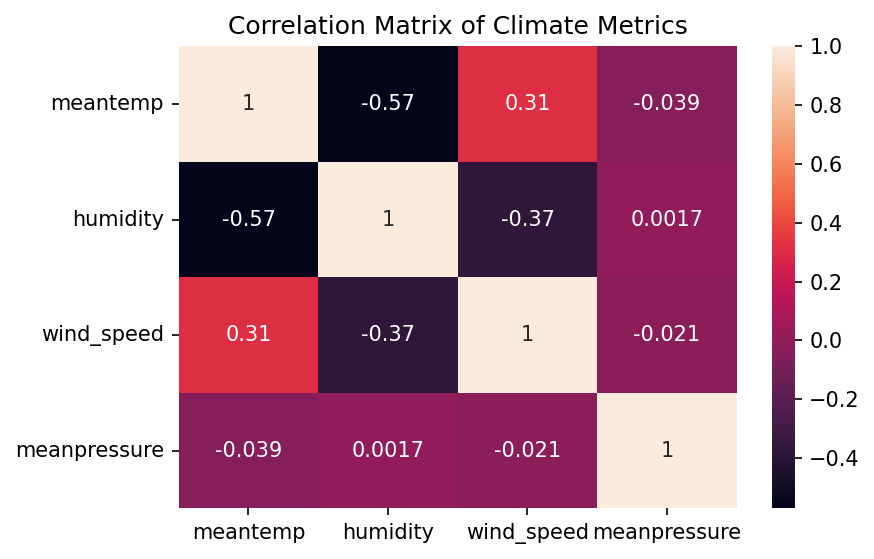

In [58]:
df_corr = df[['meantemp','humidity','wind_speed','meanpressure']].corr()
plt.figure(figsize=(6,4), dpi=150)
sns.heatmap(df_corr, annot=True)
plt.title('Correlation Matrix of Climate Metrics')

1. **Mean Temperature and Humidity:** The correlation coefficient is -0.51, indicating a **strong negative** correlation between these two variables.

2. **Mean Temperature and Mean Pressure:** The correlation coefficient is -0.44, indicating a negative correlation, although **it is not as strong as the correlation with humidity.**

3. **Humidity and Mean Pressure:** The correlation coefficient is 0.23, indicating **a weaker positive correlation** between these two variables.

4. **Wind Speed and Other Metrics:** Wind speed shows weaker correlations with the other meteorological metrics.

<a id="part4"><a/>
## Part 4: Anomaly Detection
Identify any outliers or extreme events in the data, like unusually high or low temperatures.

[<Axes: >]

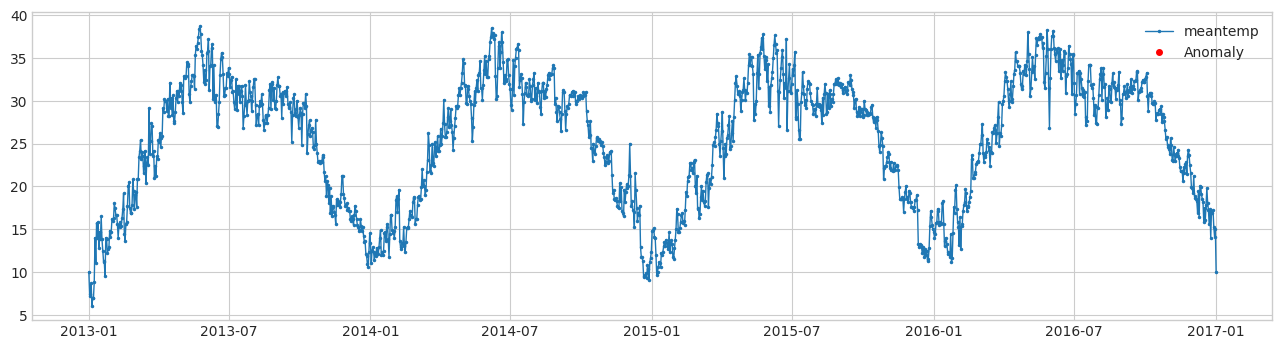

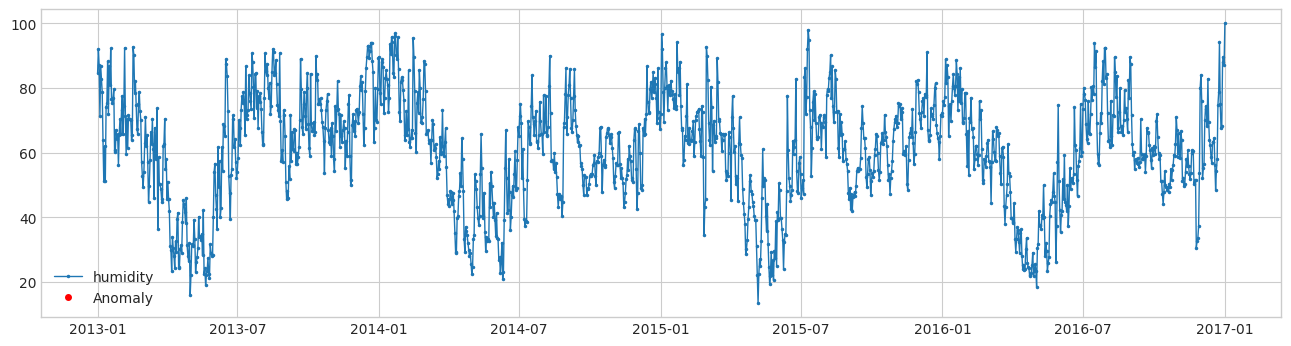

In [18]:
def plot_seasonalad(feat):
    s = validate_series(df[feat])
    seasonal_ad = SeasonalAD()
    anomalies = seasonal_ad.fit_detect(s)
    return plot(s, anomaly=anomalies, anomaly_color="red", ts_linewidth=1, ts_markersize=3, anomaly_alpha=0.3, anomaly_tag="marker", curve_group='all')

plot_seasonalad('meantemp')
plot_seasonalad('humidity')

**It appears that there are no anomaly in the seasonality.**

[<Axes: >]

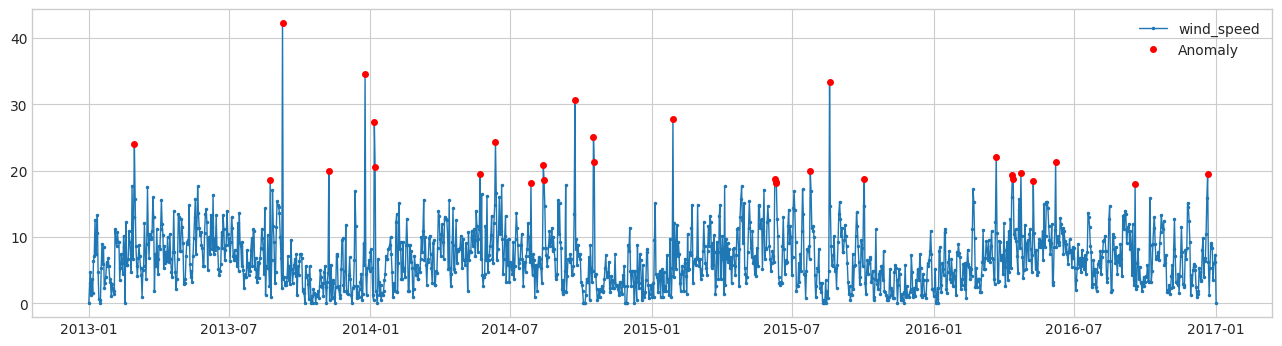

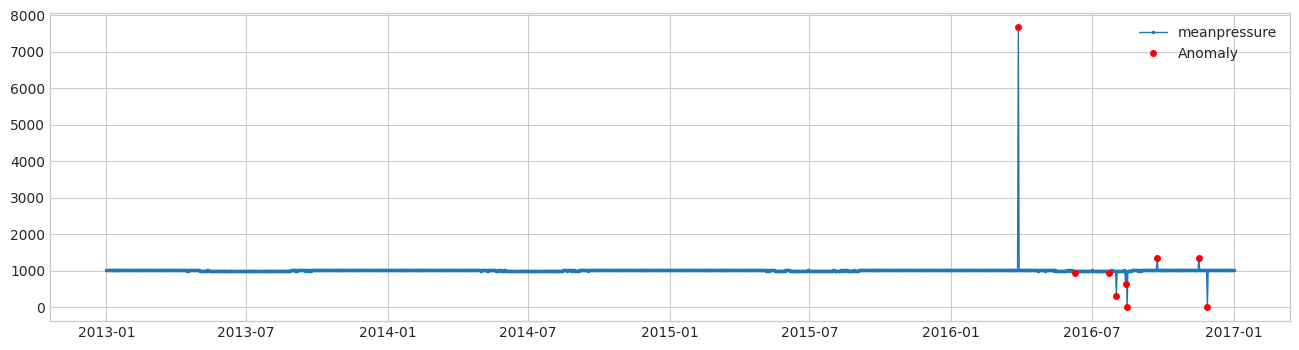

In [23]:
def plot_iqr(feat):
    s = validate_series(df[feat])
    iqr_detector = InterQuartileRangeAD(c=1.5)
    anomalies = iqr_detector.fit_detect(s)
    return plot(s, anomaly=anomalies, anomaly_color="red", ts_linewidth=1, ts_markersize=3, anomaly_alpha=0.3, anomaly_tag="marker", curve_group='all')

plot_iqr('wind_speed')
plot_iqr('meanpressure')

**It can be observed that there are some anomaly values in wind speed and mean pressure when using 1.5 times the IQR as a criterion.**

[<Axes: >]

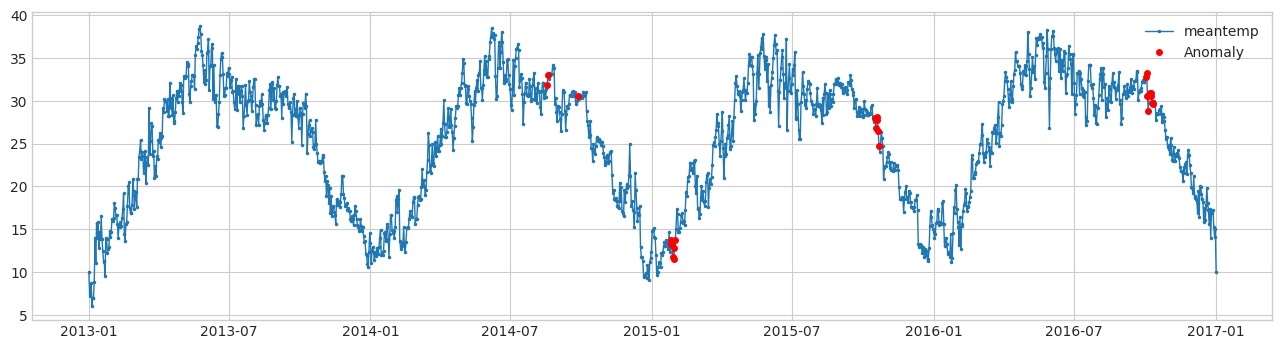

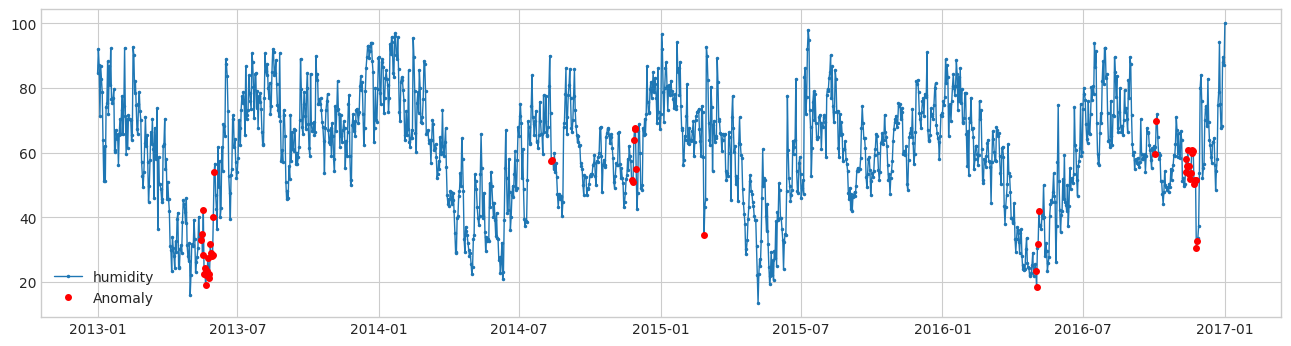

In [32]:
def plot_vol(feat):
    s = validate_series(df[feat])
    vol_detector = VolatilityShiftAD(c=2.0, side='both', window=30)
    anomalies = vol_detector.fit_detect(s)
    return plot(s, anomaly=anomalies, anomaly_color="red", ts_linewidth=1, ts_markersize=3, anomaly_alpha=0.3, anomaly_tag="marker", curve_group='all')
plot_vol('meantemp')
plot_vol('humidity')

**With Volatility Detection, we also can find some anomaly value in temperature and humidity**

<a id="part5"><a/>
## Part 5: LSTM Forecasting  
Use the historical data to build predictive models, like forecasting future average temperatures or humidity levels.

In [5]:
# Split data into train and test sets
test_size = 200
test_ind = len(df) - test_size
train = df[:test_ind]
test = df[test_ind:]
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)
X_train, y_train = scaled_train[:,1:], scaled_train[:,0]
X_test, y_test = scaled_test[:,1:], scaled_test[:,0]
# create generator
length = 120
features = X_train.shape[1]
batch_size = 64
train_generator = TimeseriesGenerator(X_train, y_train, length=length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=length, batch_size=batch_size)
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, features), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
model.fit(train_generator, validation_data=test_generator, epochs=100, callbacks=[es], verbose=0)

<Axes: >

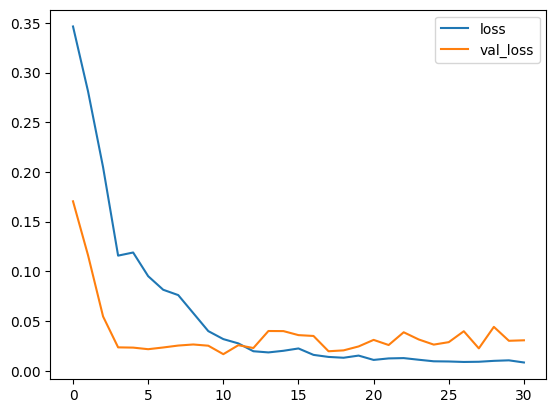

In [6]:
pd.DataFrame(model.history.history).plot()

In [41]:
X, y = train_generator[0]
print(X.shape)
print(y.shape)

(32, 36, 3)
(32,)


In [61]:
print(scaled_train.shape)
print(X_train.shape)
print(y_train.shape)
print(first_batch.shape)
print(current_batch.shape)

(1432, 4)
(1432, 3)
(1432,)
(12, 3)
(1, 12, 3)


**Finally, we can plot the predicted charts.**

Text(0, 0.5, 'Meantemp')

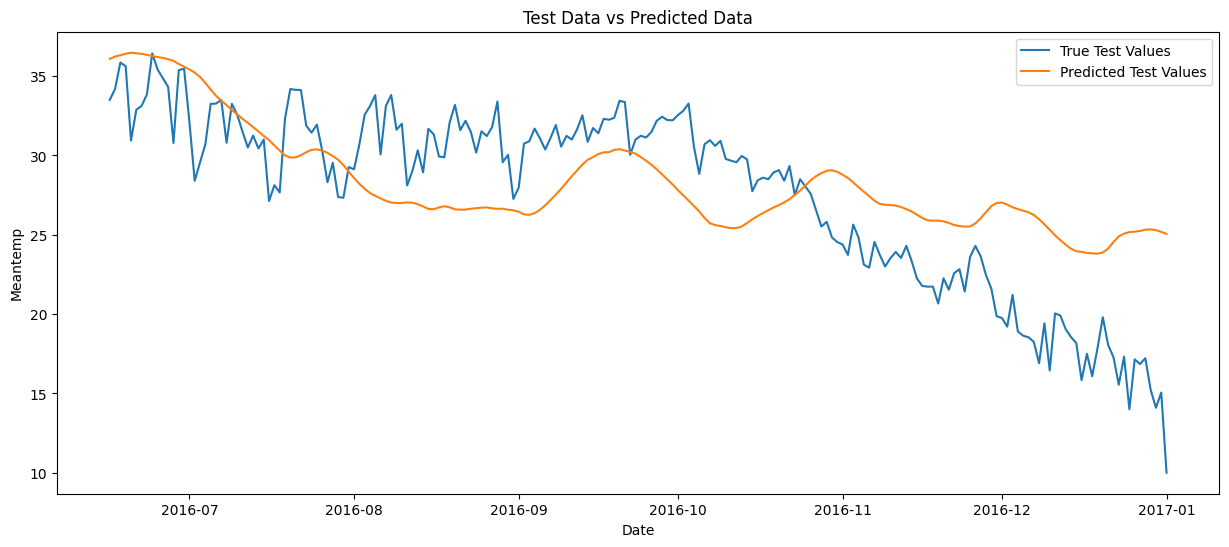

In [7]:
# Generargpartitionate predictions on the test data
test_predictions = []
first_batch = X_train[-length:]  # Get the last batch of training data (12, 3)
current_batch = first_batch.reshape((1, length, features))  # Reshape it to match the input_shape in LSTM (1, 12, 3) 因為傳入LSTM是一個batch的(length, features)

# Loop to get predictions
for i in range(len(test)):
    # Get the current prediction
    current_pred = model.predict(current_batch, verbose=0)[0] 
    
    # Store the prediction and set the new features value
    test_predictions.append(current_pred)
    new_row = X_test[i]
    # Update the current_batch to include the prediction and drop the first value
    current_batch = np.append(current_batch[:,1:,:], [[new_row]], axis=1) 

# Inverse transform the predictions
# create temp scaler only for meantemp
temp_scaler = MinMaxScaler()
temp_scaler.fit(train[['meantemp']])
true_predictions = temp_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Create a DataFrame for the true test predictions
true_predictions_df = pd.DataFrame(data=true_predictions, columns=['Predicted_Meantemp'], index=test.index)

# Plotting
plt.figure(figsize=(15,6))
plt.plot(test.index, test['meantemp'], label='True Test Values')
plt.plot(test.index, true_predictions_df['Predicted_Meantemp'], label='Predicted Test Values')
plt.legend()
plt.title('Test Data vs Predicted Data')
plt.xlabel('Date')
plt.ylabel('Meantemp')

In [8]:
y_pred = true_predictions.ravel()
y_true = test['meantemp'].values
mse = mean_squared_error(y_true, y_pred)
print(f"RMSE: {np.sqrt(mse)}")

RMSE: 4.54663246578557
